# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import joblib

# Load Data

In [2]:
df = pd.read_csv("languages.csv", encoding="utf_8")
df.dropna(inplace=True)

# Data Exploration

In [3]:
df.head(10)

,sentence,language
0,Отпустите меня!,Russian
1,今日は、少しかみがたをかえようかなと思ってるんです。,Japanese
2,"Quando decideva di fare qualcosa, lo faceva.",Italian
3,বিমানত উৰি থাকোঁতে পিয়ানো বজাই আছে।,Assamese
4,Mettersi a piangere/ridere...,Italian
5,Otthonról dolgozom.,Hungarian
6,Costă zece lei,Romanian
7,Ich habe beim Dartturnier mit einem Langbogen ...,German
8,Está na sua mala.,Portugese
9,ik heb niets te verliezen.,Dutch


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10407
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  10407 non-null  object
 1   language  10407 non-null  object
dtypes: object(2)
memory usage: 243.9+ KB


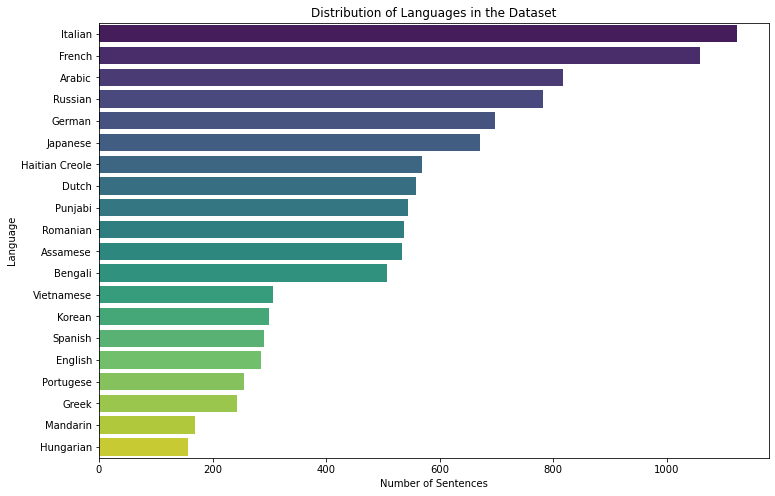

In [5]:
plt.figure(figsize=(12, 8))
sns.countplot(y='language', data=df, order=df['language'].value_counts().index, palette='viridis')
plt.title('Distribution of Languages in the Dataset')
plt.xlabel('Number of Sentences')
plt.ylabel('Language')
plt.show()

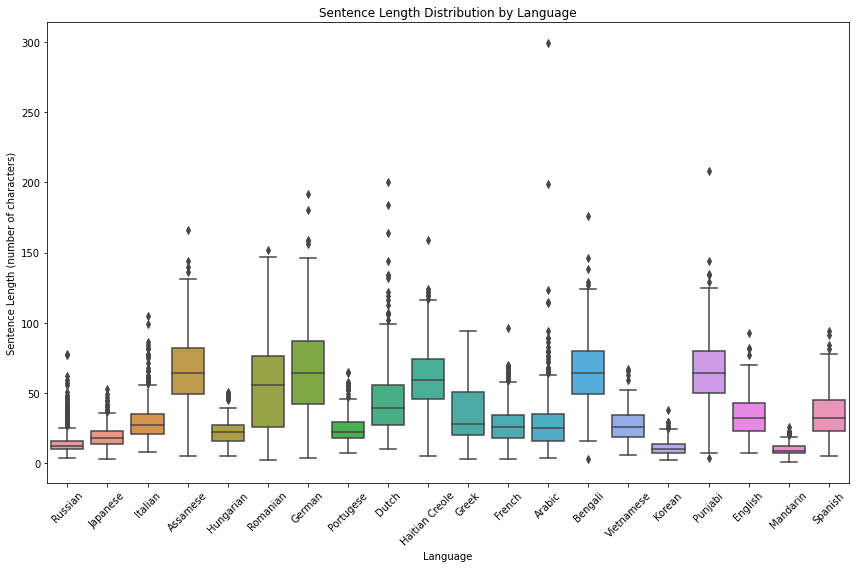

In [6]:
df['sentence_length'] = df['sentence'].astype(str).apply(len)

plt.figure(figsize=(12, 8))
sns.boxplot(x='language', y='sentence_length', data=df)
plt.title('Sentence Length Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Sentence Length (number of characters)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
print("EDA Summary")
print(f"The dataset contains {df.shape[0]} sentences across {df['language'].nunique()} languages.")
print(f"The average sentence length is {df['sentence_length'].mean():.2f} characters.")

EDA Summary
The dataset contains 10407 sentences across 20 languages.
The average sentence length is 38.54 characters.


# Preprocessing

In [8]:
df['sentence'] = (df['sentence']
                  .str.lower()
                  .str.replace(r'\d+', '', regex=True)
                  .str.replace(r'[^\w\s]', '', regex=True)
                  .str.strip()
                 )

In [9]:
X = df['sentence'].values
y = df['language'].values

In [10]:
vectorizer = CountVectorizer()
X_matrix = vectorizer.fit_transform(X)
joblib.dump(vectorizer, 'language_vectorizer.pkl')

['language_vectorizer.pkl']

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(X_matrix, y, test_size=0.2, random_state=42)

# Model Building

In [12]:
results = {}
table = []

## Logistic Regression

In [13]:
lr = LogisticRegression(max_iter=300, class_weight="balanced", random_state=42)
lr.fit(xtrain, ytrain)
ypred = lr.predict(xtest)

acc = accuracy_score(ytest, ypred)
report = classification_report(ytest, ypred, output_dict=True, zero_division=0)

table.append([
    "Logistic Regression", 
    f"{acc*100:.2f}%",
    f"{report['macro avg']['precision']:.2f}",
    f"{report['macro avg']['recall']:.2f}",
    f"{report['macro avg']['f1-score']:.2f}",
    f"{report['weighted avg']['f1-score']:.2f}"
])

joblib.dump(lr, f'model_Logistic_Regression.pkl')

['model_Logistic_Regression.pkl']

## KNN

Text(0, 0.5, 'error')

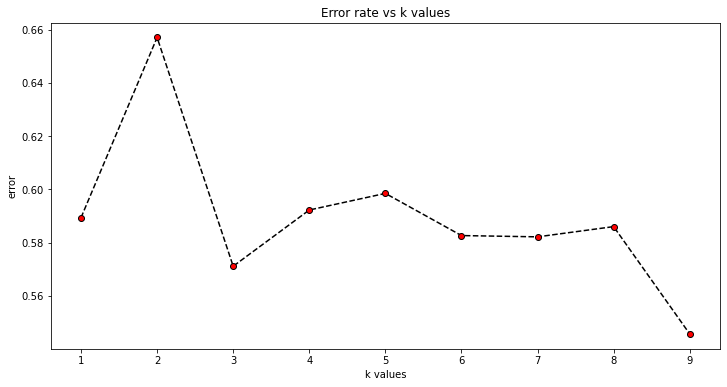

In [14]:
# Find ideal K

knn_error = []
for i in range (1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(xtrain, ytrain)
    pred_i = knn.predict(xtest)
    knn_error.append(np.mean(pred_i!=ytest))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), knn_error, color='black', linestyle='dashed', marker='o', markerfacecolor='red')
plt.title('Error rate vs k values')
plt.xlabel('k values')
plt.ylabel('error')

In [15]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(xtrain, ytrain)
ypred = knn.predict(xtest)

acc = accuracy_score(ytest, ypred)
report = classification_report(ytest, ypred, output_dict=True, zero_division=0)

table.append([
    "KNN", 
    f"{acc*100:.2f}%",
    f"{report['macro avg']['precision']:.2f}",
    f"{report['macro avg']['recall']:.2f}",
    f"{report['macro avg']['f1-score']:.2f}",
    f"{report['weighted avg']['f1-score']:.2f}"
])

joblib.dump(lr, f'model_K-Nearest_Neighbors.pkl')

['model_K-Nearest_Neighbors.pkl']

## Decision Tree

In [16]:
dt = DecisionTreeClassifier(criterion='entropy', class_weight="balanced", random_state=42)
dt.fit(xtrain, ytrain)
ypred = dt.predict(xtest)

acc = accuracy_score(ytest, ypred)
report = classification_report(ytest, ypred, output_dict=True, zero_division=0)

table.append([
    "Decision Tree", 
    f"{acc*100:.2f}%",
    f"{report['macro avg']['precision']:.2f}",
    f"{report['macro avg']['recall']:.2f}",
    f"{report['macro avg']['f1-score']:.2f}",
    f"{report['weighted avg']['f1-score']:.2f}"
])

joblib.dump(lr, f'model_Decision_Tree.pkl')

['model_Decision_Tree.pkl']

## Random Forest

Text(0, 0.5, 'error')

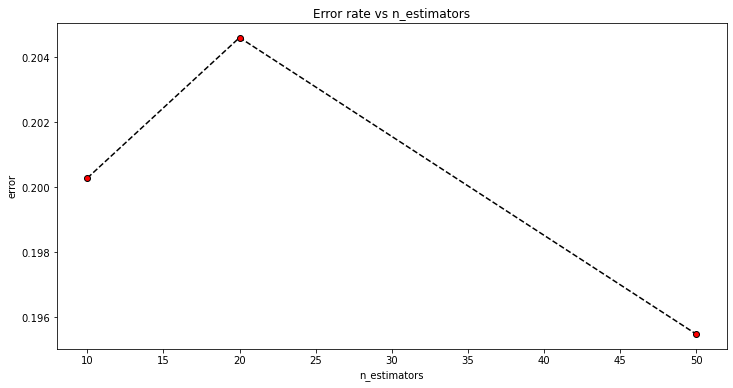

In [17]:
# Find ideal value for n_estimators

error=[]
for i in [10, 20, 50]:
    rf = RandomForestClassifier(n_estimators=i, class_weight="balanced", random_state= 42)
    rf.fit(xtrain, ytrain)
    pred_i = rf.predict(xtest)
    error.append(np.mean(pred_i != ytest))
plt.figure(figsize=(12,6))
plt.plot([10, 20, 50], error, color='black', linestyle='dashed', marker='o', markerfacecolor='red')
plt.title('Error rate vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('error')

In [18]:
rf = RandomForestClassifier(n_estimators=50, class_weight="balanced", random_state= 42)
rf.fit(xtrain, ytrain)
ypred = rf.predict(xtest)

acc = accuracy_score(ytest, ypred)
report = classification_report(ytest, ypred, output_dict=True, zero_division=0)

table.append([
    "Random Forest", 
    f"{acc*100:.2f}%",
    f"{report['macro avg']['precision']:.2f}",
    f"{report['macro avg']['recall']:.2f}",
    f"{report['macro avg']['f1-score']:.2f}",
    f"{report['weighted avg']['f1-score']:.2f}"
])

joblib.dump(lr, f'model_Random_Forest.pkl')

['model_Random_Forest.pkl']

## Multinomial Naive Bayes

In [19]:
nb = MultinomialNB()
nb.fit(xtrain, ytrain)
ypred = nb.predict(xtest)

acc = accuracy_score(ytest, ypred)
report = classification_report(ytest, ypred, output_dict=True, zero_division=0)

table.append([
    "Multinomial Naive Bayes", 
    f"{acc*100:.2f}%",
    f"{report['macro avg']['precision']:.2f}",
    f"{report['macro avg']['recall']:.2f}",
    f"{report['macro avg']['f1-score']:.2f}",
    f"{report['weighted avg']['f1-score']:.2f}"
])

joblib.dump(lr, f'model_Multinomial_Naive_Bayes.pkl')

['model_Multinomial_Naive_Bayes.pkl']

## Linear SVC

In [20]:
svc = LinearSVC(class_weight="balanced", random_state=42, dual='auto')
svc.fit(xtrain, ytrain)
ypred = svc.predict(xtest)

acc = accuracy_score(ytest, ypred)
report = classification_report(ytest, ypred, output_dict=True, zero_division=0)

table.append([
    "Linear SVC", 
    f"{acc*100:.2f}%",
    f"{report['macro avg']['precision']:.2f}",
    f"{report['macro avg']['recall']:.2f}",
    f"{report['macro avg']['f1-score']:.2f}",
    f"{report['weighted avg']['f1-score']:.2f}"
])

joblib.dump(lr, f'model_Linear_SVC.pkl')

['model_Linear_SVC.pkl']

## Model Evaluation

In [21]:
print(tabulate(table, headers=["Model", "Accuracy", "Precision", "Recall", "F1", "Weighted F1", "Best Params"]))

Model                    Accuracy      Precision    Recall    F1    Weighted F1
-----------------------  ----------  -----------  --------  ----  -------------
Logistic Regression      86.98%             0.95      0.84  0.86           0.89
KNN                      45.44%             0.76      0.4   0.46           0.5
Decision Tree            76.32%             0.83      0.77  0.78           0.8
Random Forest            80.45%             0.88      0.81  0.82           0.84
Multinomial Naive Bayes  86.55%             0.86      0.82  0.83           0.84
Linear SVC               90.97%             0.96      0.87  0.89           0.92


Linear SVC has best performance

In [23]:
text = ('أنا أحب الكلاب أيضًا ، لكني أحب القطط أكثر.') #arabic
data = vectorizer.transform([text]).toarray()
predlanguage = svc.predict(data)[0]
print(predlanguage)

Arabic


In [24]:
text = ('Főiskolai hallgató vagyok') #hungarian
data = vectorizer.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Hungarian


In [25]:
text = ('es ist heute zu heiß, wir sollten Eis essen') #german
data = vectorizer.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

German


In [26]:
text = ('También me gustan los perros, pero me gustan más los gatos.') #spanish
data = vectorizer.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Spanish


In [27]:
text = ('κάνει πολύ ζέστη σήμερα, πρέπει να φάμε παγωτό') #greek
data = vectorizer.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Greek


In [28]:
text = ('ਕੀ ਇਹ ਤੁਹਾਡੇ ਨਾਲ ਗੱਲ ਕਰਨ ਦਾ ਚੰਗਾ ਸਮਾਂ ਹੈ') #punjabi
data = vectorizer.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Punjabi


In [29]:
text = ('आज बहुत गर्मी है, हमें आइसक्रीम खानी चाहिए') #hindi, note: hindi is not a language included in the dataset
data = vectorizer.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

Japanese


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

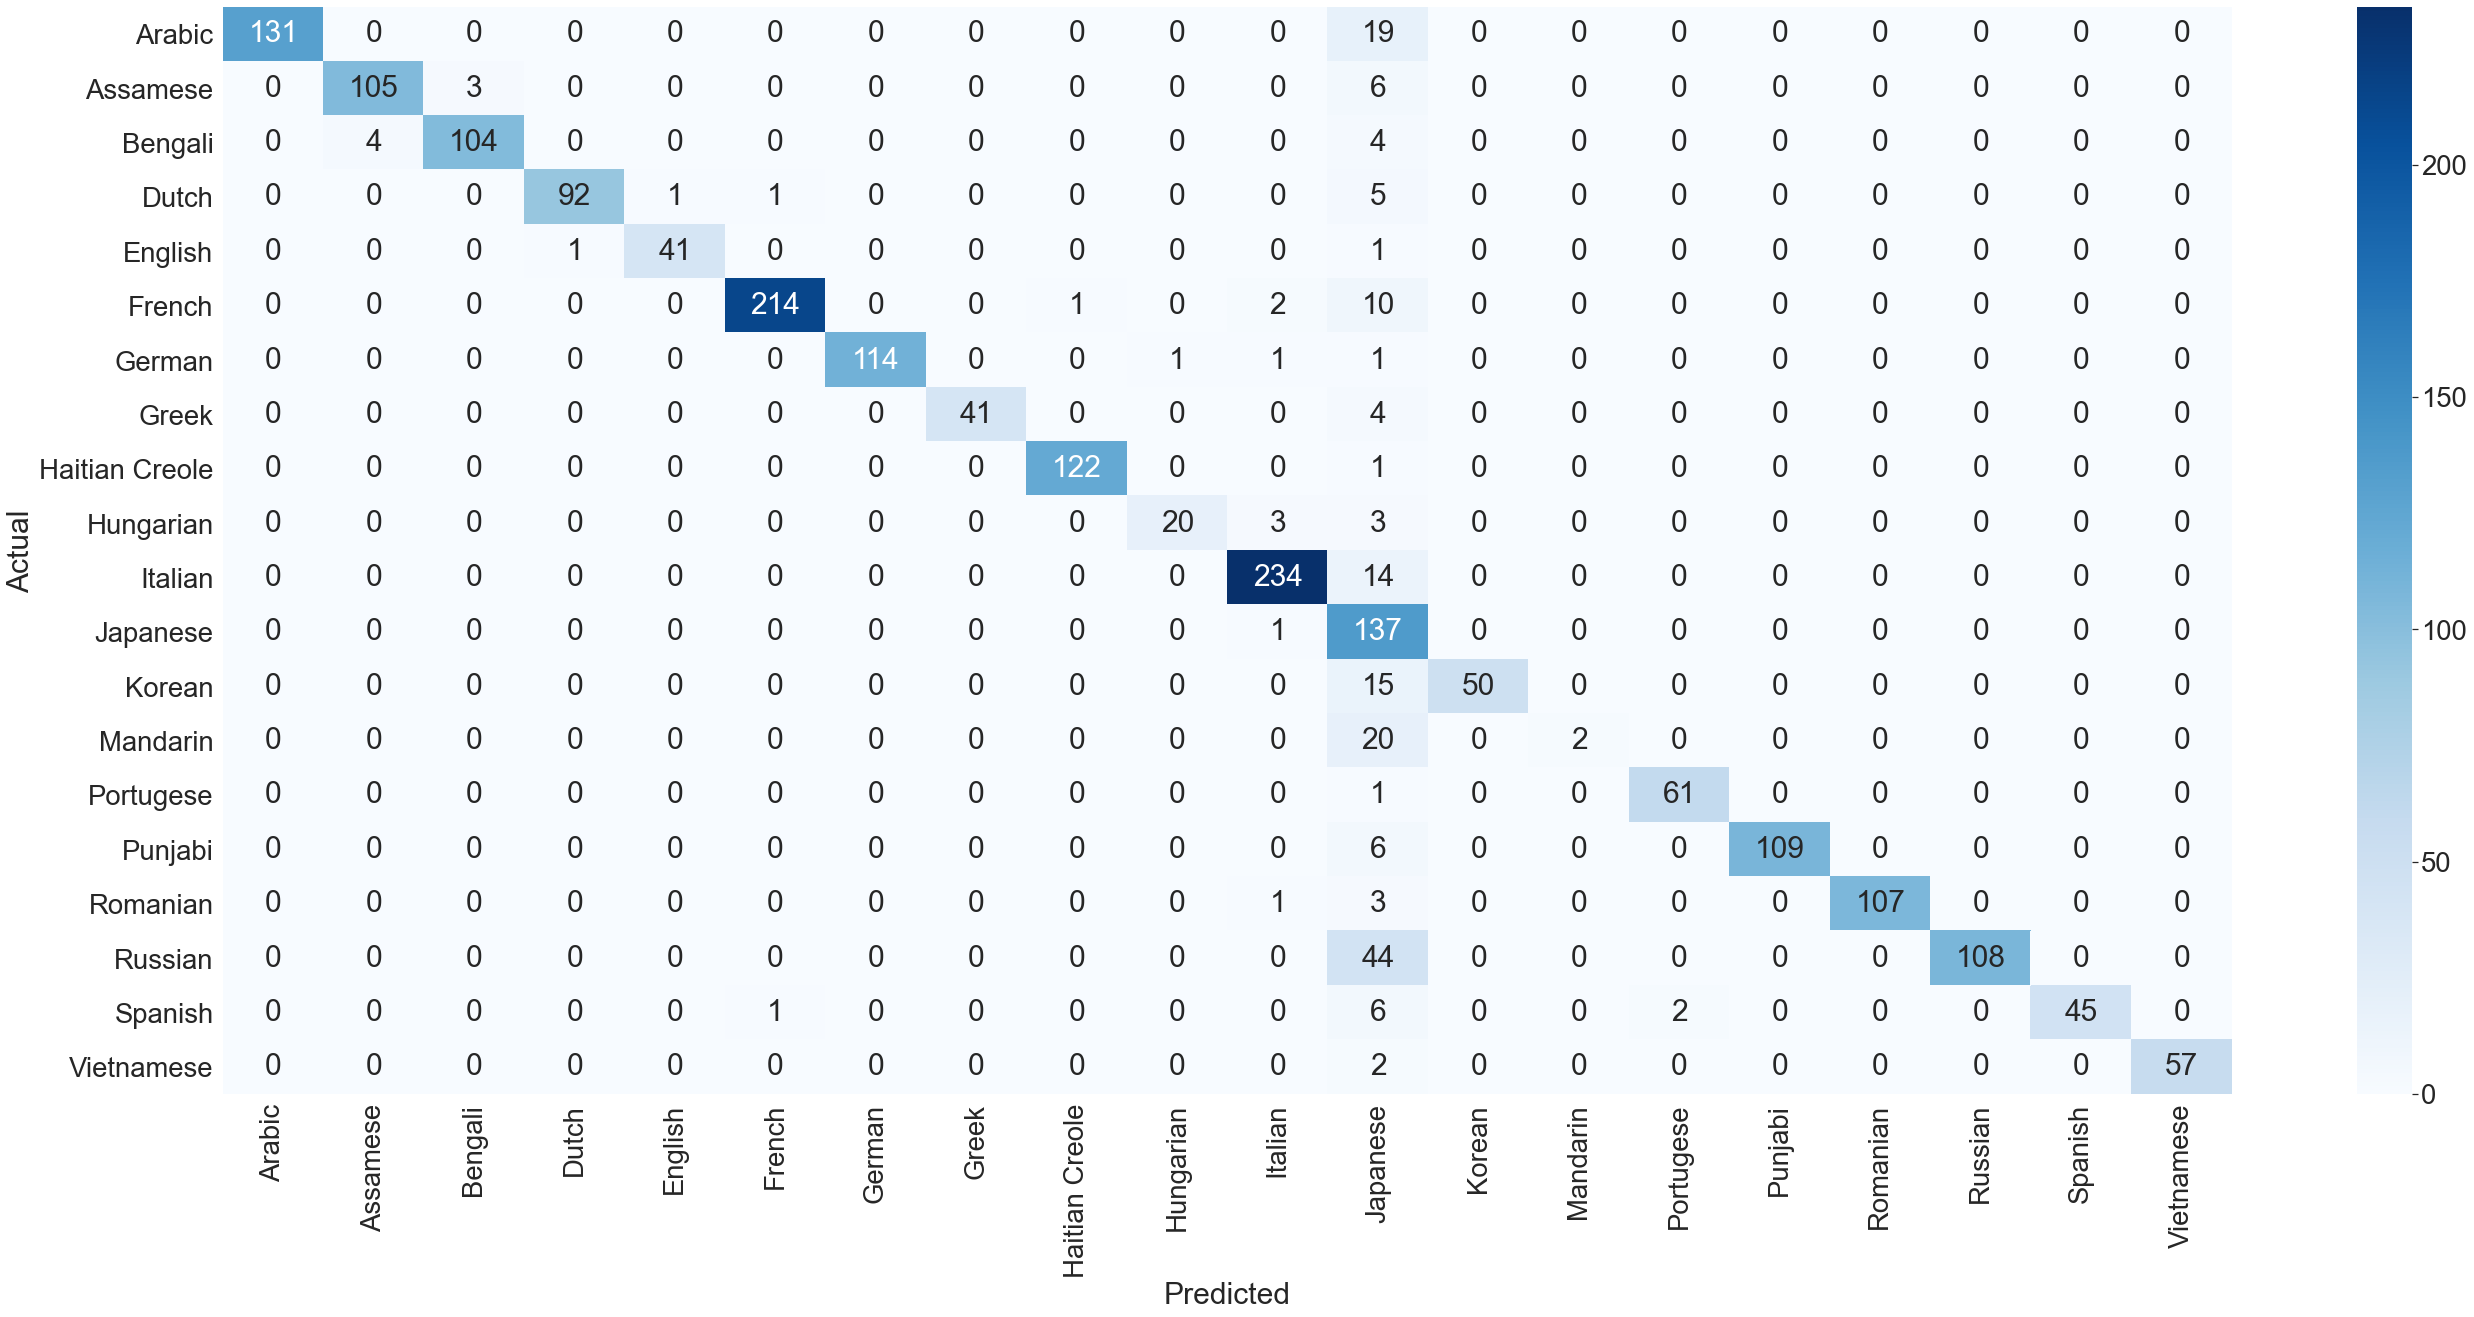

In [42]:
#Confusion Matrix for Linear SVC

np.set_printoptions(linewidth=np.inf)
labels = np.unique(ytest)
data = confusion_matrix(ytest, ypred, labels=labels)
df_cm = pd.DataFrame(data, columns=np.unique(ytest), index = np.unique(ytest))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (45,20))
sns.set(font_scale=2.5)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 30}, fmt='g')

In [43]:
# Try your own text

text = ('put text here') #tryit
data = vectorizer.transform([text]).toarray()
predlanguage=svc.predict(data)[0]
print(predlanguage)

English
